In [1]:
# from cerebralcortex.util.helper_methods import get_study_names
# sn = get_study_names("/home/jupyter/cc3_conf/")
# print(sn)
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, LongType, \
DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
import pandas as pd
from cerebralcortex import Kernel
study_name = 'md2k_aa_rice'
CC = Kernel("/home/jupyter/cc3_conf/", study_name=study_name)

In [ ]:
def compute_respiration_quality(data,
                                window_size=3,
                                outlier_threshold_high = 4000,
                                outlier_threshold_low = 20,
                                slope_threshold = 300,
                                eck_threshold_band_loose = 175,
                                eck_threshold_band_off = 20,
                                minimum_expected_samples = 3*(0.33)*21.33,
                                acceptable_outlier_percent = 34):
    
    def get_metadata(stream_name):
        stream_metadata = Metadata()
        stream_metadata.set_name(stream_name).set_description("Chest Respiration quality per sample 3 seconds") \
            .add_dataDescriptor(
            DataDescriptor().set_name("quality").set_type("string").set_attribute("description", \
            "Respiration data quality").set_attribute('Loose/Improper Attachment','Electrode Displacement').set_attribute('Sensor off Body',\
            'Autosense not worn').set_attribute('Battery down/Disconnected', \
            'No data is present - Can be due to battery down or sensor disconnection').set_attribute('Interittent Data Loss', \
             'Not enough samples are present').set_attribute('Acceptable','Good Quality')) \
            .add_dataDescriptor(
            DataDescriptor().set_name("respiration").set_type("double").set_attribute("description", \
            "respiration sample value")) \
            .add_module(
            ModuleMetadata().set_name("fourtytwo/mullah/cc3/rip_quality.ipynb").set_attribute("url", "http://md2k.org/").set_author(
                "Md Azim Ullah", "mullah@memphis.edu"))
        return stream_metadata
    
    def get_quality(data):
        data_quality_band_loose = 'Loose/Improper Attachment'
        data_quality_not_worn = 'Sensor off Body'
        data_quality_band_off = 'Battery down/Disconnected'
        data_quality_missing = 'Interittent Data Loss' 
        data_quality_good = 'Acceptable'
        if (len(data)== 0):
            return data_quality_band_off
        range_data = max(data)-min(data)
        if range_data<=eck_threshold_band_off:
            return data_quality_not_worn
        if (len(data)<=minimum_expected_samples) :
            return data_quality_missing
        if range_data<=eck_threshold_band_loose:
            return data_quality_band_loose

        outlier_counts = 0 
        for i in range(0,len(data)):
            im,ip  = i,i
            if i==0:
                im = len(data)-1
            else:
                im = i-1
            if i == len(data)-1:
                ip = 0
            else:
                ip = ip+1
            stuck = ((data[i]==data[im]) and (data[i]==data[ip]))
            flip = ((abs(data[i]-data[im])>((int(outlier_threshold_high)))) or (abs(data[i]-data[ip])>((int(outlier_threshold_high)))))
            disc = ((abs(data[i]-data[im])>((int(slope_threshold)))) and (abs(data[i]-data[ip])>((int(slope_threshold)))))
            if disc:
                outlier_counts += 1
            elif stuck:
                outlier_counts +=1
            elif flip:
                outlier_counts +=1
            elif data[i] >= outlier_threshold_high:
                outlier_counts +=1
            elif data[i]<= outlier_threshold_low:
                outlier_counts +=1
        if (100*outlier_counts>acceptable_outlier_percent*len(data)):
            return data_quality_band_loose
        return data_quality_good

    schema = StructType([
        StructField("timestamp", TimestampType()),
        StructField("localtime", TimestampType()),
        StructField("version", IntegerType()),
        StructField("user", StringType()),
        StructField("quality", StringType()),
        StructField("respiration", DoubleType())
    ])
    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def ecg_quality(key,data):
        data['quality'] = ''
        if data.shape[0]>0:
            data = data.sort_values('timestamp')
            data['quality'] = get_quality(list(data['respiration']))
        return data

    stream_name = 'org.md2k.autosense.rip.quality.per.sample'
    rip_quality_stream = rip.compute(ecg_quality,windowDuration=window_size,startTime='0 seconds')
    data = rip_quality_stream._data
    ds = DataStream(data=data,metadata=get_metadata(stream_name))
    return ds




rip_stream = 'respiration--org.md2k.autosense--autosense_chest--chest'
rip = CC.get_stream(rip_stream)
ds = compute_respiration_quality(rip)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.quality.per.sample').count()

In [ ]:
from collections import Counter
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("quality", StringType())
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_quality_60(key,data):
    if data.shape[0]>0:
        quals = list(data['quality'].values)
        qual = Counter(quals).most_common()[0][0]
        data = data[:1].reset_index(drop=True)
        data['quality'].set_value(0,qual)
        data['start'] = [key[2]['start']]
        data['end'] = [key[2]['end']]
        return data[['start','end','timestamp','localtime','version','user','quality']]
    else:
        return pd.DataFrame([],columns=['start','end','timestamp','localtime','version','user','quality'])

stream_name = 'org.md2k.autosense.rip.quality.60seconds'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Chest RIP quality 60 seconds") \
    .add_dataDescriptor(
    DataDescriptor().set_name("quality").set_type("string").set_attribute("description", \
    "ECG data quality").set_attribute('Loose/Improper Attachment','Electrode Displacement').set_attribute('Sensor off Body',\
    'Autosense not worn').set_attribute('Battery down/Disconnected', \
    'No data is present - Can be due to battery down or sensor disconnection').set_attribute('Interittent Data Loss', \
     'Not enough samples are present').set_attribute('Acceptable','Good Quality')) \
    .add_dataDescriptor(
    DataDescriptor().set_name("window").set_type("struct").set_attribute("description", \
    "window start and end time in UTC").set_attribute('start', \
    'start of 1 minute window').set_attribute('end','end of 1 minute window')) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/respiration_peak_valley.ipynb").set_attribute("url", "http://md2k.org/").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))

stream_metadata.is_valid()
ecg_stream = 'org.md2k.autosense.rip.quality.per.sample'
ecg = CC.get_stream(ecg_stream)
ecg_quality_stream = ecg.compute(ecg_quality_60,windowDuration=60,startTime='0 seconds')
ecg_quality_stream = ecg_quality_stream.select('timestamp', F.struct('start', 'end').alias('window'),
                                   'localtime','quality','user','version')
ecg_quality_stream.printSchema()
data = ecg_quality_stream._data
ds = DataStream(data=data,metadata=stream_metadata)
CC.save_stream(ds)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.quality.60seconds').count()

In [ ]:
from typing import List
from enum import Enum
import numpy as np
from copy import deepcopy
from operator import itemgetter
# TODO: What is this?
class Quality(Enum):
    ACCEPTABLE = 1
    UNACCEPTABLE = 0
from operator import itemgetter

def smooth(data:np.ndarray,
           span: int = 5)-> np.ndarray:
    """

    :rtype: object
    :param data:
    :param span:
    :return:
    """
    if data is None or len(data) == 0:
        return []
    # plt.figure()
    # plt.plot(data[:,1])
    sample = data[:,1]
    sample_middle = np.convolve(sample, np.ones(span, dtype=int), 'valid') / span
    divisor = np.arange(1, span - 1, 2)
    sample_start = np.cumsum(sample[:span - 1])[::2] / divisor
    sample_end = (np.cumsum(sample[:-span:-1])[::2] / divisor)[::-1]
    sample_smooth = np.concatenate((sample_start, sample_middle, sample_end))
    data[:,1] = sample_smooth

    # plt.plot(data[:,1])
    # plt.show()
    return data


def moving_average_curve(data: np.ndarray,
                         window_length: int) -> np.ndarray:
    """
    Moving average curve from filtered (using moving average) samples.

    :rtype: object
    :return: mac
    :param data:
    :param window_length:
    """
    if data is None or len(data) == 0:
        return []
    # plt.figure()
    # plt.plot(data[:,1])
    sample = data[:,1]
    for i in range(window_length, len(sample) - (window_length + 1)):
        sample_avg = np.mean(sample[i - window_length:i + window_length + 1])
        data[i,1] = sample_avg

    # plt.plot(data[:,1])
    # plt.show()
    return data[np.array(range(window_length, len(sample) - (window_length + 1)))]


def up_down_intercepts(data: np.ndarray,
                       mac: np.ndarray,
                       data_start_time_to_index: dict) -> [np.ndarray, np.ndarray]:
    """
    Returns Up and Down Intercepts.
    Moving Average Centerline curve intersects breath cycle twice. Once in the inhalation branch
    (Up intercept) and in the exhalation branch (Down intercept).

    :param data_start_time_to_index:
    :rtype: object
    :return up_intercepts, down_intercepts:
    :param data:
    :param mac:
    """

    up_intercepts = []
    down_intercepts = []

    subsets = []
    for i in range(len(mac)):
        data_index = data_start_time_to_index[mac[i,0]]
        subsets.append(data[data_index,1])
    # plt.plot(data[:,0],data[:,1])
    # plt.plot(mac[:,0],mac[:,1])
    # # plt.plot(mac[:,0],subsets)
    # plt.show()
    if len(subsets) == len(mac):
        for i in range(len(mac) - 1):
            if subsets[i] <= mac[i,1] and mac[i + 1,1] <= subsets[i + 1]:
                up_intercepts.append(mac[i + 1])
            elif subsets[i] >= mac[i,1] and mac[i + 1,1] >= subsets[i + 1]:
                down_intercepts.append(mac[i + 1])
    else:
        raise Exception("Data sample not found at Moving Average Curve.")

    return up_intercepts, down_intercepts

def filter_intercept_outlier(up_intercepts: List,
                             down_intercepts: List) -> [List,List]:
    """
    Remove two or more consecutive up or down intercepts.

    :rtype: object
    :return up_intercepts_updated, down_intercepts_updated:
    :param up_intercepts:
    :param down_intercepts:
    """

    up_intercepts_filtered = []
    down_intercepts_filtered = []

    for index in range(len(down_intercepts) - 1):
        up_intercepts_between_down_intercepts = []
        for ui in up_intercepts:
            if down_intercepts[index][0] <= ui[0] <= down_intercepts[index + 1][0]:
                up_intercepts_between_down_intercepts.append(ui)

        if len(up_intercepts_between_down_intercepts) > 0:
            up_intercepts_filtered.append(up_intercepts_between_down_intercepts[-1])

    up_intercepts_after_down = [ui for ui in up_intercepts if ui[0] > down_intercepts[-1][0]]
    if len(up_intercepts_after_down) > 0:
        up_intercepts_filtered.append(up_intercepts_after_down[-1])

    down_intercepts_before_up = [di for di in down_intercepts if di[0] < up_intercepts_filtered[0][0]]
    if len(down_intercepts_before_up) > 0:
        down_intercepts_filtered.append(down_intercepts_before_up[-1])

    for index in range(len(up_intercepts_filtered) - 1):
        down_intercepts_between_up_intercepts = []
        for di in down_intercepts:
            if up_intercepts_filtered[index][0] <= di[0] <= up_intercepts_filtered[index + 1][0]:
                down_intercepts_between_up_intercepts.append(di)

        if len(down_intercepts_between_up_intercepts) > 0:
            down_intercepts_filtered.append(down_intercepts_between_up_intercepts[-1])

    down_intercepts_after_up = [di for di in down_intercepts if di[0] > up_intercepts_filtered[-1][0]]
    if len(down_intercepts_after_up) > 0:
        down_intercepts_filtered.append(down_intercepts_after_up[-1])

    up_intercepts_truncated = []
    for ui in up_intercepts_filtered:
        if ui[0] >= down_intercepts_filtered[0][0]:
            up_intercepts_truncated.append(ui)

    min_length = min(len(up_intercepts_truncated), len(down_intercepts_filtered))

    up_intercepts_updated = up_intercepts_truncated[:min_length]
    down_intercepts_updated = down_intercepts_filtered[:min_length]

    return up_intercepts_updated, down_intercepts_updated



def generate_peak_valley(up_intercepts: List,
                         down_intercepts: List,
                         data: np.ndarray) -> [List, List]:
    """
    Compute peak valley from up intercepts and down intercepts indices.

    :rtype: object
    :return peaks, valleys:
    :param up_intercepts:
    :param down_intercepts:
    :param data:
    """
    peaks = []
    valleys = []

    last_iterated_index = 0
    for i in range(len(down_intercepts) - 1):
        peak = None
        valley = None

        for j in range(last_iterated_index, len(data)):
            if down_intercepts[i][0] <= data[j][0] <= up_intercepts[i][0]:
                if valley is None or data[j][1] < valley[1]:
                    valley = data[j]
            elif up_intercepts[i][0] <= data[j][0] <= down_intercepts[i + 1][0]:
                if peak is None or data[j][1] > peak[1]:
                    peak = data[j]
            elif data[j][0] > down_intercepts[i + 1][0]:
                last_iterated_index = j
                break
        if peak is None or valley is None:
            continue

        valleys.append(valley)
        peaks.append(peak)

    return peaks, valleys


def correct_valley_position(peaks: List,
                            valleys: List,
                            up_intercepts: List,
                            data: np.ndarray,
                            data_start_time_to_index: dict) -> List:
    """
    Correct Valley position by locating actual valley using maximum slope algorithm which is
    located between current valley and following peak.

    Algorithm - push valley towards right:
    Search for points lies in between current valley and following Up intercept.
    Calculate slopes at those points.
    Ensure that valley resides at the begining of inhalation cycle where inhalation slope is maximum.

    :rtype: object
    :return valley_updated:
    :param peaks:
    :param valleys:
    :param up_intercepts:
    :param data:
    :param data_start_time_to_index: hash table for data where start_time is key, index is value
    """
    valley_updated = valleys.copy()
    for i in range(len(valleys)):
        if valleys[i][0] < up_intercepts[i][0] < peaks[i][0]:
            up_intercept = up_intercepts[i]

            if valleys[i][0] not in data_start_time_to_index or up_intercept[0] not in data_start_time_to_index:
                exception_message = 'Data has no start time for valley or up intercept start time at index ' + str(i)
                raise Exception(exception_message)
            else:
                valley_index = data_start_time_to_index[valleys[i][0]]
                up_intercept_index = data_start_time_to_index[up_intercept[0]]
                data_valley_to_ui = data[valley_index: up_intercept_index + 1]
                sample_valley_to_ui = data_valley_to_ui[:,1]

                slope_at_samples = np.diff(sample_valley_to_ui)

                consecutive_positive_slopes = [-1] * len(slope_at_samples)

                for j in range(len(slope_at_samples)):
                    slopes_subset = slope_at_samples[j:]
                    if all(slope > 0 for slope in slopes_subset):
                        consecutive_positive_slopes[j] = len(slopes_subset)

                if any(no_con_slope > 0 for no_con_slope in consecutive_positive_slopes):
                    indices_max_pos_slope = []
                    for k in range(len(consecutive_positive_slopes)):
                        if consecutive_positive_slopes[k] == max(consecutive_positive_slopes):
                            indices_max_pos_slope.append(k)
                    valley_updated[i] = data_valley_to_ui[indices_max_pos_slope[-1]]

        else:
            # TODO: discuss whether raise exception or not
            # Up intercept at index i is not between valley and peak at index i.
            break

    return valley_updated


def correct_peak_position(peaks: List,
                          valleys: List,
                          up_intercepts: List,
                          data: np.ndarray,
                          max_amplitude_change_peak_correction: float,
                          min_neg_slope_count_peak_correction: int,
                          data_start_time_to_index: dict) -> List:
    """
    Correct peak position by checking if there is a notch in the inspiration branch at left position.
    If at least 60% inspiration is done at a notch point, assume that notch as an original peak.
    Our hypothesis is most of breathing in done for that cycle. We assume insignificant amount of
    breath is taken or some new cycle started after the notch.

    :rtype: object
    :return peaks:
    :param peaks:
    :param valleys:
    :param up_intercepts:
    :param data:
    :param max_amplitude_change_peak_correction:
    :param min_neg_slope_count_peak_correction:
    :param data_start_time_to_index: hash table for data where start_time is key, index is value

    """
    for i, item in enumerate(peaks):
        if valleys[i][0] < up_intercepts[i][0] < peaks[i][0]:
            up_intercept = up_intercepts[i]
            # points between current valley and UI.
            if up_intercept[0] not in data_start_time_to_index or peaks[i][0] not in data_start_time_to_index:
                exception_message = 'Data has no start time for peak or up intercept start time at index ' + str(i)
#                 raise Exception(exception_message)
                return np.array([])
            else:
                data_up_intercept_index = data_start_time_to_index[up_intercept[0]]
                data_peak_index = data_start_time_to_index[peaks[i][0]]

                data_ui_to_peak = data[data_up_intercept_index: data_peak_index + 1]

                sample_ui_to_peak = data_ui_to_peak[:,1]
                slope_at_samples = np.diff(sample_ui_to_peak)

                if not all(j >= 0 for j in slope_at_samples):
                    indices_neg_slope = [j for j in range(len(slope_at_samples)) if slope_at_samples[j] < 0]
                    peak_new = data_ui_to_peak[indices_neg_slope[0]]
                    valley_peak_dist_new = peak_new[1] - valleys[i][1]
                    valley_peak_dist_prev = peaks[i][1] - valleys[i][1]
                    if valley_peak_dist_new == 0:
                        return np.array([])
                    else:
                        amplitude_change = (valley_peak_dist_prev - valley_peak_dist_new) / valley_peak_dist_new * 100.0

                        if len(indices_neg_slope) >= min_neg_slope_count_peak_correction:
                            if amplitude_change <= max_amplitude_change_peak_correction:
                                peaks[i] = peak_new  # 60% inspiration is done at that point.

        else:
            # TODO: Discuss whether raise exception or not for this scenario.
            break  # up intercept at i is not between valley and peak at i

    return peaks


def remove_close_valley_peak_pair(peaks: List,
                                  valleys: List,
                                  minimum_peak_to_valley_time_diff: float = 0.31) -> [List, List]:
    """
    Filter out too close valley peak pair.

    :rtype: object
    :return peaks_updated, valleys_updated:
    :param peaks:
    :param valleys:
    :param minimum_peak_to_valley_time_diff:
    """

    peaks_updated = []
    valleys_updated = []

    for i, item in enumerate(peaks):
        time_diff_valley_peak = peaks[i][0] - valleys[i][0]
        if time_diff_valley_peak/1000 > minimum_peak_to_valley_time_diff:
            peaks_updated.append(peaks[i])
            valleys_updated.append(valleys[i])

    return peaks_updated, valleys_updated

def filter_expiration_duration_outlier(peaks: List,
                                       valleys: List,
                                       threshold_expiration_duration: float) -> [List, List]:
    """
    Filter out peak valley pair for which expiration duration is too small.

    :rtype: object
    :return peaks_updated, valleys_updated:
    :param peaks:
    :param valleys:
    :param threshold_expiration_duration:
    """

    peaks_updated = []
    valleys_updated = [valleys[0]]

    for i, item in enumerate(peaks):
        if i < len(peaks) - 1:
            expiration_duration = valleys[i + 1][0] - peaks[i][0]
            if expiration_duration/1000 > threshold_expiration_duration:
                peaks_updated.append(peaks[i])
                valleys_updated.append(valleys[i + 1])

    peaks_updated.append(peaks[-1])

    return peaks_updated, valleys_updated


def filter_small_amp_expiration_peak_valley(peaks: List,
                                            valleys: List,
                                            expiration_amplitude_threshold_perc: float) -> [List, List]:
    """
    Filter out peak valley pair if their expiration amplitude is less than or equal to 10% of
    average expiration amplitude.

    :rtype: object
    :return: peaks_updated, valleys_updated:
    :param: peaks:
    :param: valleys:
    :param: expiration_amplitude_threshold_perc:
    """

    expiration_amplitudes = []
    peaks_updated = []
    valleys_updated = [valleys[0]]

    for i, peak in enumerate(peaks):
        if i < len(peaks) - 1:
            expiration_amplitudes.append(abs(valleys[i + 1][1] - peak[1]))

    mean_expiration_amplitude = np.mean(expiration_amplitudes)

    for i, expiration_amplitude in enumerate(expiration_amplitudes):
        if expiration_amplitude > expiration_amplitude_threshold_perc * mean_expiration_amplitude:
            peaks_updated.append(peaks[i])
            valleys_updated.append(valleys[i + 1])

    peaks_updated.append(peaks[-1])

    return peaks_updated, valleys_updated


def filter_small_amp_inspiration_peak_valley(peaks: List,
                                             valleys: List,
                                             inspiration_amplitude_threshold_perc: float) -> [List,List]:
    """
    Filter out peak valley pair if their inspiration amplitude is less than or to equal 10% of
    average inspiration amplitude.

    :rtype: object
    :return peaks_updated, valleys_updated:
    :param peaks:
    :param valleys:
    :param inspiration_amplitude_threshold_perc:
    """

    peaks_updated = []
    valleys_updated = []

    inspiration_amplitudes = [(peaks[i][1] - valleys[i][1]) for i, valley in enumerate(valleys)]
    mean_inspiration_amplitude = np.mean(inspiration_amplitudes)

    for i, inspiration_amplitude in enumerate(inspiration_amplitudes):
        if inspiration_amplitude > inspiration_amplitude_threshold_perc * mean_inspiration_amplitude:
            valleys_updated.append(valleys[i])
            peaks_updated.append(peaks[i])

    return peaks_updated, valleys_updated


def compute_peak_valley(rip: np.ndarray,
                        fs: float = 21.33,
                        smoothing_factor: int = 5,
                        time_window: int = 8,
                        expiration_amplitude_threshold_perc: float = 0.10,
                        threshold_expiration_duration: float = 0.312,
                        inspiration_amplitude_threshold_perc: float = 0.10,
                        max_amplitude_change_peak_correction: float = 30,
                        min_neg_slope_count_peak_correction: int = 4,
                        minimum_peak_to_valley_time_diff=0.31) -> [np.ndarray, np.ndarray]:
    """
    Compute peak and valley from rip data and filter peak and valley.

    :rtype: object
    :param minimum_peak_to_valley_time_diff:
    :param inspiration_amplitude_threshold_perc:
    :param smoothing_factor:
    :return peak_datastream, valley_datastream:
    :param rip:
    :param rip_quality:
    :param fs:
    :param time_window:
    :param expiration_amplitude_threshold_perc:
    :param threshold_expiration_duration:
    :param max_amplitude_change_peak_correction:
    :param min_neg_slope_count_peak_correction:
    """

    rip_filtered = rip
#     print(rip_filtered.shape)
    data_smooth = smooth(data=rip_filtered, span=smoothing_factor)
#     print(data_smooth.shape)
    window_length = int(round(time_window * fs))
    # plt.figure()
    # plt.plot(rip_filtered[:,0],rip_filtered[:,1])
    # plt.plot(data_smooth[:,0],data_smooth[:,1])
    # # plt.plot(data_mac[:,0],data_mac[:,1])
    # plt.show()
    data_mac = moving_average_curve(deepcopy(data_smooth), window_length=window_length)

    data_smooth_start_time_to_index = {}
    for index, data in enumerate(data_smooth):
        data_smooth_start_time_to_index[data_smooth[index,0]] = index

    up_intercepts, down_intercepts = up_down_intercepts(data=data_smooth,
                                                        mac=data_mac,
                                                        data_start_time_to_index=data_smooth_start_time_to_index)
    if len(up_intercepts)<3 or len(down_intercepts)<3:
        return np.array([]),np.array([])
    # print(up_intercepts,down_intercepts)
    up_intercepts_filtered, down_intercepts_filtered = filter_intercept_outlier(up_intercepts=up_intercepts,
                                                                                down_intercepts=down_intercepts)
    if len(up_intercepts_filtered)<3 or len(down_intercepts_filtered)<3:
        return np.array([]),np.array([])
    peaks, valleys = generate_peak_valley(up_intercepts=up_intercepts_filtered,
                                          down_intercepts=down_intercepts_filtered,
                                          data=data_smooth)
    if len(peaks)<3 or len(valleys)<3:
        return np.array([]),np.array([])

    valleys_corrected = correct_valley_position(peaks=peaks,
                                                valleys=valleys,
                                                up_intercepts=up_intercepts_filtered,
                                                data=data_smooth,
                                                data_start_time_to_index=data_smooth_start_time_to_index)

    if len(valleys_corrected)<3:
        return np.array([]),np.array([])
    peaks_corrected = correct_peak_position(peaks=peaks,
                                            valleys=valleys_corrected,
                                            up_intercepts=up_intercepts_filtered,
                                            data=data_smooth,
                                            max_amplitude_change_peak_correction=max_amplitude_change_peak_correction,
                                            min_neg_slope_count_peak_correction=min_neg_slope_count_peak_correction,
                                            data_start_time_to_index=data_smooth_start_time_to_index)
    if len(peaks_corrected)<3:
        return np.array([]),np.array([])
    # remove too close valley peak pair.
    peaks_filtered_close, valleys_filtered_close = remove_close_valley_peak_pair(peaks=peaks_corrected,
                                                                                 valleys=valleys_corrected,
                                                                                 minimum_peak_to_valley_time_diff=minimum_peak_to_valley_time_diff)
    if len(peaks_filtered_close)<3 or len(valleys_filtered_close)<3:
        return np.array([]),np.array([])
    # Remove small  Expiration duration < 0.31
    peaks_filtered_exp_dur, valleys_filtered_exp_dur = filter_expiration_duration_outlier(peaks=peaks_filtered_close,
                                                                                          valleys=valleys_filtered_close,
                                                                                          threshold_expiration_duration=threshold_expiration_duration)
    if len(peaks_filtered_exp_dur)<3 or len(valleys_filtered_exp_dur)<3:
        return np.array([]),np.array([])
    # filter out peak valley pair of inspiration of small amplitude.
    peaks_filtered_insp_amp, valleys_filtered_insp_amp = filter_small_amp_inspiration_peak_valley(
        peaks=peaks_filtered_exp_dur,
        valleys=valleys_filtered_exp_dur,
        inspiration_amplitude_threshold_perc=inspiration_amplitude_threshold_perc)
    if len(peaks_filtered_insp_amp)<3 or len(valleys_filtered_insp_amp)<3:
        return np.array([]),np.array([])
    # filter out peak valley pair of expiration of small amplitude.
    peaks_filtered_exp_amp, valleys_filtered_exp_amp = filter_small_amp_expiration_peak_valley(
        peaks=peaks_filtered_insp_amp,
        valleys=valleys_filtered_insp_amp,
        expiration_amplitude_threshold_perc=expiration_amplitude_threshold_perc)
    if len(peaks_filtered_exp_amp)<3 or len(valleys_filtered_exp_amp)<3:
        return np.array([]),np.array([])
    
    peaks_filtered_exp_amp, valleys_filtered_exp_amp = np.array(peaks_filtered_exp_amp), np.array(valleys_filtered_exp_amp)
    # peaks_filtered_exp_amp = np.insert(peaks_filtered_exp_amp,
    # peaks_filtered_exp_amp =  np.insert(peaks_filtered_exp_amp, 2, 5, axis=1)
    # valleys_filtered_exp_amp =  np.insert(valleys_filtered_exp_amp, 2, 5, axis=1)
    # peaks_filtered_exp_amp[:,2] = [data_smooth_start_time_to_index[i[0]] for i in peaks_filtered_exp_amp]
    # valleys_filtered_exp_amp[:,2] = [data_smooth_start_time_to_index[i[0]] for i in valleys_filtered_exp_amp]
    return np.array(itemgetter(*list(peaks_filtered_exp_amp[:,0]))(data_smooth_start_time_to_index)),\
    np.array(itemgetter(*list(valleys_filtered_exp_amp[:,0]))(data_smooth_start_time_to_index))

rip_stream = 'org.md2k.autosense.rip.quality.per.sample'
rip_data = CC.get_stream(rip_stream)

rip_data.show(5,False)
rip_clean_data = rip_data.filter(F.col('quality')=='Acceptable')

schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("respiration", DoubleType()),
    StructField("indicator", StringType())
])

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def peak_valley(key,data):
    if data.shape[0]>2*21.33*10:
        data = data.sort_values('time').reset_index(drop=True)
        r = np.zeros((data.shape[0],2))
        r[:,0] = 1000*data['time'].values
        r[:,1] = data['respiration'].values
        peak_index,valley_index = compute_peak_valley(r)
        data['indicator'] = 1
        data['indicator'].loc[peak_index] = 'p'
        data['indicator'].loc[valley_index] = 'v'
        data = data[data.indicator.isin(['p','v'])]
        return data[['timestamp','localtime','version','user','indicator','respiration']]
    else:
        return pd.DataFrame([],columns=['timestamp','localtime','version','user','indicator','respiration'])
rip_clean_data = rip_clean_data.withColumn('time',F.col('timestamp').cast('double'))
peak_valley_data = rip_clean_data.compute(peak_valley,windowDuration=60,startTime='0 seconds')

stream_name = 'org.md2k.autosense.rip.peak.valley'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Peak Valley of Autosense Respiration") \
    .add_dataDescriptor(
    DataDescriptor().set_name("indicator").set_type("string").set_attribute("description", \
    "Peak and valley indicator in respiration signal")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("respiration").set_type("double").set_attribute("description", \
    "respiration amplitude")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/respiration_peak_valley.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','Peak Valley').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))

peak_valley_data.metadata = stream_metadata

CC.save_stream(peak_valley_data,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.peak.valley').count()

In [ ]:
def rip_cycle_feature_computation(peaks_datastream: np.ndarray,
                                  valleys_datastream: np.ndarray) -> np.ndarray:
    """
    Respiration Feature Implementation. The respiration feature values are
    derived from the following paper:
    'puffMarker: a multi-sensor approach for pinpointing the timing of first lapse in smoking cessation'
    Removed due to lack of current use in the implementation
    roc_max = []  # 8. ROC_MAX = max(sample[j]-sample[j-1])
    roc_min = []  # 9. ROC_MIN = min(sample[j]-sample[j-1])

    :param peaks_datastream: list of peak datapoints
    :param valleys_datastream: list of valley datapoints
    :return: lists of DataPoints each representing a specific feature calculated from the respiration cycle
    found from the peak valley inputs
    """

    inspiration_duration = []  # 1 Inhalation duration
    expiration_duration = []  # 2 Exhalation duration
    respiration_duration = []  # 3 Respiration duration
    inspiration_expiration_ratio = []  # 4 Inhalation and Exhalation ratio
    stretch = []  # 5 Stretch
    upper_stretch = []  # 6. Upper portion of the stretch calculation
    lower_stretch = []  # 7. Lower portion of the stretch calculation
    delta_previous_inspiration_duration = []  # 10. BD_INSP = INSP(i)-INSP(i-1)
    delta_previous_expiration_duration = []  # 11. BD_EXPR = EXPR(i)-EXPR(i-1)
    delta_previous_respiration_duration = []  # 12. BD_RESP = RESP(i)-RESP(i-1)
    delta_previous_stretch_duration = []  # 14. BD_Stretch= Stretch(i)-Stretch(i-1)
    delta_next_inspiration_duration = []  # 19. FD_INSP = INSP(i)-INSP(i+1)
    delta_next_expiration_duration = []  # 20. FD_EXPR = EXPR(i)-EXPR(i+1)
    delta_next_respiration_duration = []  # 21. FD_RESP = RESP(i)-RESP(i+1)
    delta_next_stretch_duration = []  # 23. FD_Stretch= Stretch(i)-Stretch(i+1)
    neighbor_ratio_expiration_duration = []  # 29. D5_EXPR(i) = EXPR(i) / avg(EXPR(i-2)...EXPR(i+2))
    neighbor_ratio_stretch_duration = []  # 32. D5_Stretch = Stretch(i) / avg(Stretch(i-2)...Stretch(i+2))

    valleys = valleys_datastream
    peaks = peaks_datastream[:-1]

    for i, peak in enumerate(peaks):
        valley_start_time = valleys[i][0]
        valley_end_time = valleys[i + 1][0]

        delta = peak[0] - valleys[i][0]
        inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        delta = valleys[i + 1][0] - peak[0]
        expiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        delta = valleys[i + 1][0] - valley_start_time
        respiration_duration.append(np.array([valley_start_time,valley_end_time,delta/1000]))

        ratio = (peak[0] - valley_start_time) / (valleys[i + 1][0] - peak[0])
        inspiration_expiration_ratio.append(np.array([valley_start_time,valley_end_time,ratio]))

        value = peak[1] - valleys[i + 1][1]
        stretch.append(np.array([valley_start_time,valley_end_time,value]))

    for i, point in enumerate(inspiration_duration):
        valley_start_time = valleys[i][0]
        valley_end_time = valleys[i + 1][0]
        if i == 0:  # Edge case
            delta_previous_inspiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_expiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_respiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_previous_stretch_duration.append(np.array([valley_start_time,valley_end_time,0]))
        else:
            delta = inspiration_duration[i][2] - inspiration_duration[i - 1][2]
            delta_previous_inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = expiration_duration[i][2] - expiration_duration[i - 1][2]
            delta_previous_expiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = respiration_duration[i][2] - respiration_duration[i - 1][2]
            delta_previous_respiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = stretch[i][2] - stretch[i - 1][2]
            delta_previous_stretch_duration.append(np.array([valley_start_time,valley_end_time,delta]))

        if i == len(inspiration_duration) - 1:
            delta_next_inspiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_expiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_respiration_duration.append(np.array([valley_start_time,valley_end_time,0]))
            delta_next_stretch_duration.append(np.array([valley_start_time,valley_end_time,0]))
        else:
            delta = inspiration_duration[i][2] - inspiration_duration[i + 1][2]
            delta_next_inspiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = expiration_duration[i][2] - expiration_duration[i + 1][2]
            delta_next_expiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = respiration_duration[i][2] - respiration_duration[i + 1][2]
            delta_next_respiration_duration.append(np.array([valley_start_time,valley_end_time,delta]))

            delta = stretch[i][2] - stretch[i + 1][2]
            delta_next_stretch_duration.append(np.array([valley_start_time,valley_end_time,delta]))

        stretch_average = 0
        expiration_average = 0
        count = 0.0
        for j in [-2, -1, 1, 2]:
            if i + j < 0 or i + j >= len(inspiration_duration):
                continue
            stretch_average += stretch[i + j][2]
            expiration_average += expiration_duration[i + j][2]
            count += 1

        stretch_average /= count
        expiration_average /= count

        ratio = stretch[i][2] / stretch_average
        neighbor_ratio_stretch_duration.append(np.array([valley_start_time,valley_end_time,ratio]))

        ratio = expiration_duration[i][2] / expiration_average
        neighbor_ratio_expiration_duration.append(np.array([valley_start_time,valley_end_time,ratio]))

    # Begin assembling datastream for output
    inspiration_duration_datastream = np.array(inspiration_duration)[1:-1]

    expiration_duration_datastream = np.array(expiration_duration)[1:-1]

    respiration_duration_datastream = np.array(respiration_duration)[1:-1]

    inspiration_expiration_ratio_datastream = np.array(inspiration_expiration_ratio)[1:-1]

    stretch_datastream = np.array(stretch)[1:-1]

    delta_previous_inspiration_duration_datastream = np.array(delta_previous_inspiration_duration)[1:-1]

    delta_previous_expiration_duration_datastream = np.array(delta_previous_expiration_duration)[1:-1]

    delta_previous_respiration_duration_datastream = np.array(delta_previous_respiration_duration)[1:-1]

    delta_previous_stretch_duration_datastream = np.array(delta_previous_stretch_duration)[1:-1]

    delta_next_inspiration_duration_datastream = np.array(delta_next_inspiration_duration)[1:-1]

    delta_next_expiration_duration_datastream = np.array(delta_next_expiration_duration)[1:-1]

    delta_next_respiration_duration_datastream = np.array(delta_next_respiration_duration)[1:-1]

    delta_next_stretch_duration_datastream = np.array(delta_next_stretch_duration)[1:-1]

    neighbor_ratio_expiration_datastream = np.array(neighbor_ratio_expiration_duration)[1:-1]

    neighbor_ratio_stretch_datastream = np.array(neighbor_ratio_stretch_duration)[1:-1]

    return np.concatenate([inspiration_duration_datastream,
                           expiration_duration_datastream[:,2].reshape(-1,1),
                           respiration_duration_datastream[:,2].reshape(-1,1),
                           inspiration_expiration_ratio_datastream[:,2].reshape(-1,1),
                           stretch_datastream[:,2].reshape(-1,1),
                           delta_previous_inspiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_expiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_respiration_duration_datastream[:,2].reshape(-1,1),
                           delta_previous_stretch_duration_datastream[:,2].reshape(-1,1),
                           delta_next_inspiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_expiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_respiration_duration_datastream[:,2].reshape(-1,1),
                           delta_next_stretch_duration_datastream[:,2].reshape(-1,1),
                           neighbor_ratio_expiration_datastream[:,2].reshape(-1,1),
                           neighbor_ratio_stretch_datastream[:,2].reshape(-1,1)],axis=1)
stream_name = 'org.md2k.autosense.rip.peak.valley'

data = CC.get_stream(stream_name)

data_time = data.withColumn('time',1000*F.col('timestamp').cast('double'))

# data_time.sort('timestamp').show(5,False)

schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("inspiration", DoubleType()),
    StructField("expiration", DoubleType()),
    StructField("respiration", DoubleType()),
    StructField("ieratio", DoubleType()),
    StructField("stretch", DoubleType()),
    StructField("pinspiration", DoubleType()),
    StructField("pexpiration", DoubleType()),
    StructField("prespiration", DoubleType()),
    StructField("pstretch", DoubleType()),
    StructField("ninspiration", DoubleType()),
    StructField("nexpiration", DoubleType()),
    StructField("nrespiration", DoubleType()),
    StructField("nstretch", DoubleType()),
    StructField("rexpiration", DoubleType()),
    StructField("rstretch", DoubleType())    
])


@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def peak_valley(key,data):
    columns = ['inspiration','expiration','respiration','ieratio',
          'stretch','pinspiration','pexpiration','prespiration','pstretch',
          'ninspiration','nexpiration','nrespiration','nstretch','rexpiration','rstretch']
    if data.shape[0]>8:
        index_dict = {}
        data = data.sort_values('time').reset_index(drop=True)
        for i in range(data.shape[0]):
            index_dict[data['time'].loc[i]] = i
        peak_data = data[data.indicator.isin(['p'])]
        valley_data = data[data.indicator.isin(['v'])]
        peaks = peak_data[['time','respiration']].values
        valleys = valley_data[['time','respiration']].values
        features = rip_cycle_feature_computation(peaks,valleys)
        timestamp_col = data['timestamp'].values
        localtime_col = data['localtime'].values
        user_id = data['user'].values[0]
        version_id = data['version'].values[0]
        data1 = pd.DataFrame()
        ind_col_1 = np.array([index_dict[features[i][0]] for i in range(features.shape[0])])
        ind_col_2 = np.array([index_dict[features[i][1]] for i in range(features.shape[0])])
        timestamp_col_s = timestamp_col[ind_col_1]
        timestamp_col_e = timestamp_col[ind_col_2]
        localtime_col = localtime_col[ind_col_1]
        data1['timestamp'] = timestamp_col_s
        data1['start'] = timestamp_col_s
        data1['end'] = timestamp_col_e
        data1['localtime'] = localtime_col
        data1['user'] = [user_id]*timestamp_col_e.reshape(-1).shape[0]
        data1['version'] = [version_id]*timestamp_col_e.reshape(-1).shape[0]
        for i in range(2,features.shape[1],1):
            data1[columns[i-2]] = list(features[:,i])
        return data1
    else:
        return pd.DataFrame([],columns=columns+['user','version','timestamp','localtime','start','end'])


respiration_features = data_time.compute(peak_valley,windowDuration=240,startTime='0 seconds')

# respiration_features.sort('timestamp').show(5,False)
respiration_features.printSchema()

stream_name = 'org.md2k.autosense.rip.cycle.features'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Features from autosense respiration") \
    .add_dataDescriptor(
    DataDescriptor().set_name("start").set_type("timestamp").set_attribute("description", \
    "start time of cycle")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("end").set_type("timestamp").set_attribute("description", \
    "end time of cycle")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("inspiration").set_type("double").set_attribute("description", \
    "inspiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("expiration").set_type("double").set_attribute("description", \
    "expiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("respiration").set_type("double").set_attribute("description", \
    "respiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("ieratio").set_type("double").set_attribute("description", \
    "inspiration to expiration ratio")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("stretch").set_type("double").set_attribute("description", \
    "cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pinspiration").set_type("double").set_attribute("description", \
    "previous cycle inspiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pexpiration").set_type("double").set_attribute("description", \
    "previous cycle expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("prespiration").set_type("double").set_attribute("description", \
    "previous cycle respiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pstretch").set_type("double").set_attribute("description", \
    "previous cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("ninspiration").set_type("double").set_attribute("description", \
    "next cycle inspiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nexpiration").set_type("double").set_attribute("description", \
    "next cycle expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nrespiration").set_type("double").set_attribute("description", \
    "next cycle respiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nstretch").set_type("double").set_attribute("description", \
    "next cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("rexpiration").set_type("double").set_attribute("description", \
    "ratio of neighbor expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("rstretch").set_type("double").set_attribute("description", \
    "ratio of neighbor stretch")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/respiration_peak_valley.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','cycle features').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
respiration_features.metadata = stream_metadata
CC.save_stream(respiration_features,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.cycle.features').count()

In [ ]:
rr_stream = 'org.md2k.autosense.rip.cycle.features'
rr_intervals = CC.get_stream(rr_stream)
rr_intervals.show(5,False)
rr_intervals = rr_intervals.withColumn('day',F.date_format('localtime',"yyyyMMdd"))

columns = ['inspiration','expiration','respiration','ieratio',
          'stretch','pinspiration','pexpiration','prespiration','pstretch',
          'ninspiration','nexpiration','nrespiration','nstretch','rexpiration','rstretch']
from pyspark.sql import Window
import pyspark.sql.functions as F

df_90 = []
for c in columns:
    percentile_90 = F.expr('percentile_approx('+str(c)+',0.90)')
    temp = rr_intervals.groupBy(['user','day']).agg(percentile_90.alias(str(c)))
    df_90.append(temp.toPandas())

from copy import deepcopy
df_90_final = deepcopy(df_90[0])
for i in range(1,len(df_90),1):
    df_90_final = df_90_final.join(df_90[i].set_index(['user','day']),on=['user','day'], how='left')

df_90_final.set_index(['user','day'],inplace=True)

df_10 = []
for c in columns:
    percentile_10 = F.expr('percentile_approx('+str(c)+',0.10)')
    temp = rr_intervals.groupBy(['user','day']).agg(percentile_10.alias(str(c)))
    df_10.append(temp.toPandas())

from copy import deepcopy
df_10_final = deepcopy(df_10[0])
for i in range(1,len(df_10),1):
    df_10_final = df_10_final.join(df_10[i].set_index(['user','day']),on=['user','day'], how='left')

df_10_final.set_index(['user','day'],inplace=True)

# df_10_final.loc['c64ca471-369e-43fa-a07b-8260fd1c745c','20190612']['inspiration']

df_90_final.head()

schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("inspiration", DoubleType()),
    StructField("expiration", DoubleType()),
    StructField("respiration", DoubleType()),
    StructField("ieratio", DoubleType()),
    StructField("stretch", DoubleType()),
    StructField("pinspiration", DoubleType()),
    StructField("pexpiration", DoubleType()),
    StructField("prespiration", DoubleType()),
    StructField("pstretch", DoubleType()),
    StructField("ninspiration", DoubleType()),
    StructField("nexpiration", DoubleType()),
    StructField("nrespiration", DoubleType()),
    StructField("nstretch", DoubleType()),
    StructField("rexpiration", DoubleType()),
    StructField("rstretch", DoubleType()),
    StructField("day", StringType())
])


@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def peak_valley(data):
    columns = ['inspiration','expiration','respiration','ieratio',
          'stretch','pinspiration','pexpiration','prespiration','pstretch',
          'ninspiration','nexpiration','nrespiration','nstretch','rexpiration','rstretch']
    if data.shape[0]>1:
        user = data['user'].loc[0]
        day = data['day'].loc[0]
        for c in columns:
            upper = df_90_final.loc[user,day][c]
            lower = df_10_final.loc[user,day][c]
            data[c][data[c]>upper] = upper
            data[c][data[c]<lower] = lower
        return data
    else:
        return pd.DataFrame([],columns=columns+['user','version','timestamp','localtime','start','end','day'])

rr_intervals_winsorized = rr_intervals.groupBy(['user','day']).apply(peak_valley)

rr_intervals_winsorized.show(5,False)
stream_name = 'org.md2k.autosense.rip.cycle.features.winsorized'
stream_metadata = Metadata()
stream_metadata.set_name(stream_name).set_description("Features from autosense respiration") \
    .add_dataDescriptor(
    DataDescriptor().set_name("start").set_type("timestamp").set_attribute("description", \
    "start time of cycle")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("end").set_type("timestamp").set_attribute("description", \
    "end time of cycle")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("inspiration").set_type("double").set_attribute("description", \
    "inspiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("expiration").set_type("double").set_attribute("description", \
    "expiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("respiration").set_type("double").set_attribute("description", \
    "respiration duration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("ieratio").set_type("double").set_attribute("description", \
    "inspiration to expiration ratio")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("stretch").set_type("double").set_attribute("description", \
    "cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pinspiration").set_type("double").set_attribute("description", \
    "previous cycle inspiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pexpiration").set_type("double").set_attribute("description", \
    "previous cycle expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("prespiration").set_type("double").set_attribute("description", \
    "previous cycle respiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("pstretch").set_type("double").set_attribute("description", \
    "previous cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("ninspiration").set_type("double").set_attribute("description", \
    "next cycle inspiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nexpiration").set_type("double").set_attribute("description", \
    "next cycle expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nrespiration").set_type("double").set_attribute("description", \
    "next cycle respiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("nstretch").set_type("double").set_attribute("description", \
    "next cycle stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("rexpiration").set_type("double").set_attribute("description", \
    "ratio of neighbor expiration")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("rstretch").set_type("double").set_attribute("description", \
    "ratio of neighbor stretch")) \
    .add_dataDescriptor(
    DataDescriptor().set_name("day").set_type("string").set_attribute("description", \
    "day localtime")) \
    .add_module(
    ModuleMetadata().set_name("fourtytwo/mullah/cc3/respiration_percentiles.ipynb").set_attribute("url", \
    "http://md2k.org/").set_attribute('algorithm','cycle features winsorized').set_attribute('unit', \
    'ms').set_author("Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
rr_intervals_winsorized_final =DataStream(data=rr_intervals_winsorized,metadata=stream_metadata)
CC.save_stream(rr_intervals_winsorized_final,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.cycle.features.winsorized').count()

In [ ]:
stream_name = 'org.md2k.autosense.rip.cycle.features.winsorized'
df = CC.get_stream(stream_name)
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("m_inspiration", DoubleType()),
    StructField("s_inspiration", DoubleType()),
    StructField("80_inspiration", DoubleType()),
    StructField("20_inspiration", DoubleType()),
    StructField("m_expiration", DoubleType()),
    StructField("s_expiration", DoubleType()),
    StructField("80_expiration", DoubleType()),
    StructField("20_expiration", DoubleType()),
    StructField("m_respiration", DoubleType()),
    StructField("s_respiration", DoubleType()),
    StructField("80_respiration", DoubleType()),
    StructField("20_respiration", DoubleType()),
    StructField("m_ieratio", DoubleType()),
    StructField("s_ieratio", DoubleType()),
    StructField("80_ieratio", DoubleType()),
    StructField("20_ieratio", DoubleType()),
    StructField("m_stretch", DoubleType()),
    StructField("s_stretch", DoubleType()),
    StructField("80_stretch", DoubleType()),
    StructField("20_stretch", DoubleType()),
    StructField("m_pinspiration", DoubleType()),
    StructField("s_pinspiration", DoubleType()),
    StructField("80_pinspiration", DoubleType()),
    StructField("20_pinspiration", DoubleType()),
    StructField("m_pexpiration", DoubleType()),
    StructField("s_pexpiration", DoubleType()),
    StructField("80_pexpiration", DoubleType()),
    StructField("20_pexpiration", DoubleType()),
    StructField("m_rexpiration", DoubleType()),
    StructField("s_rexpiration", DoubleType()),
    StructField("80_rexpiration", DoubleType()),
    StructField("20_rexpiration", DoubleType()),
    StructField("m_rstretch", DoubleType()),
    StructField("s_rstretch", DoubleType()),
    StructField("80_rstretch", DoubleType()),
    StructField("20_rstretch", DoubleType()),
    StructField("day", StringType()),
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def minute_level_rip_features(key,data):
    ms82 = ['m_','s_','80_','20_']
    all_columns = ['start','end','timestamp','localtime','user','version','day']
    columns = ['inspiration','expiration','respiration','ieratio',
          'stretch','pinspiration','pexpiration','rexpiration','rstretch']
    if data.shape[0]>5:
        all_data = []
        all_data.extend([key[2]['start'],key[2]['end'],data['timestamp'].loc[0],
                        data['localtime'].loc[0],data['user'].loc[0],data['version'].loc[0],
                        data['day'].loc[0]])
        data = data[columns]
        list_col = [list(data.mean()),list(data.std()),
                    list(data.quantile(.8)),list(data.quantile(.2))]
        for i,c in enumerate(ms82):
            all_columns.extend([c+j for j in columns])
            all_data.extend(list_col[i])
        return pd.DataFrame([all_data],columns=all_columns)
    else:
        for i,c in enumerate(ms82):
            all_columns.extend([c+j for j in columns])
        return pd.DataFrame([],columns=all_columns)
df_minutewise = df.compute(minute_level_rip_features,windowDuration=60,startTime='0 seconds',slideDuration=5)
ms82 = ['m_','s_','80_','20_']
all_columns = [F.struct('start', 'end').alias('window'),'timestamp',
               'localtime','user','version','day']
columns = ['inspiration','expiration','respiration','ieratio',
      'stretch','pinspiration','pexpiration','rexpiration','rstretch']
for i,c in enumerate(ms82):
    all_columns.extend([c+j for j in columns])
df_minutewise = df_minutewise.select(*all_columns)
df_minutewise.show(2)
schema = df_minutewise._data.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.rip.minute.features').set_description("Respiration Minute Features")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("Respiration Minute Level Features") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
print(stream_metadata.is_valid(),'metadata')
ds = DataStream(data=df_minutewise._data,metadata=stream_metadata)
ds.printSchema()
CC.save_stream(ds,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.minute.features').sort('window').select('window','timestamp').count()

In [ ]:
CC.get_stream('org.md2k.autosense.rip.minute.features').sort('window').select('window','timestamp').show(3,False)

In [ ]:
rip_data = CC.get_stream('org.md2k.autosense.rip.minute.features')
activity_data = CC.get_stream('org.md2k.autosense.accel.activity.60seconds')

df = rip_data.join(activity_data.drop(*['timestamp','localtime','version']),on=['user','window'],how='left')
df = df.filter(F.col('activity')!=1)
df = df.drop(*['activity'])
df = df.withColumn('start',F.col('window').start)
df = df.withColumn('end',F.col('window').end).drop(*['window'])

# df.printSchema()
ms82 = ['m_','s_','80_','20_']
all_columns = ['start','end','timestamp','localtime','user','version','day']
columns = ['inspiration','expiration','respiration','ieratio',
          'stretch','pinspiration','pexpiration','rexpiration','rstretch']
feature_columns = []
for i,c in enumerate(ms82):
    feature_columns.extend([c+j for j in columns])
    all_columns.extend([c+j for j in columns])

df = df.select(*all_columns)
# all_columns
# df.count()
# CC.get_stream('org.md2k.autosense.rip.minute.features').count()

feature_columns_action_std = [F.stddev(i).alias(i) for i in feature_columns]
feature_columns_action_mean = [F.mean(i).alias(i) for i in feature_columns]

std_all = df.groupBy(['user','day']).agg(*feature_columns_action_std)
mean_all = df.groupBy(['user','day']).agg(*feature_columns_action_mean)

mean_all = mean_all.toPandas()
std_all = std_all.toPandas()
mean_all.set_index(['user','day'],inplace=True)
std_all.set_index(['user','day'],inplace=True)

basic_schema = StructType([
            StructField("timestamp", TimestampType()),
            StructField("localtime", TimestampType()),
            StructField("user", StringType()),
            StructField("day", StringType()),
            StructField("version", IntegerType()),
            StructField("start", TimestampType()),
            StructField("end", TimestampType())
])

features_list = []
for c in feature_columns:
    features_list.append(StructField(c, DoubleType(), True))
features_schema = StructType(basic_schema.fields + features_list)

@pandas_udf(features_schema, PandasUDFType.GROUPED_MAP)
def standardize_rip_feature(data):
    if data.shape[0]>10:
        for c in feature_columns:
            m = mean_all.loc[data.loc[0]['user'],data.loc[0]['day']][c]
            s = std_all.loc[data.loc[0]['user'],data.loc[0]['day']][c]
            data[c] = (data[c] - m)/s
        return data
    else:
        return pd.DataFrame([],columns=all_columns)

df_standardized = df.groupBy(['user','day']).apply(standardize_rip_feature)
columns = ['m_inspiration', 'm_expiration', 'm_respiration',
       'm_ieratio', 'm_stretch', 'm_pinspiration', 'm_pexpiration',
       'm_rexpiration', 'm_rstretch', 's_inspiration', 's_expiration',
       's_respiration', 's_ieratio', 's_stretch', 's_pinspiration',
       's_pexpiration', 's_rexpiration', 's_rstretch', '80_inspiration',
       '80_expiration', '80_respiration', '80_ieratio', '80_stretch',
       '80_pinspiration', '80_pexpiration', '80_rexpiration', '80_rstretch',
       '20_inspiration', '20_expiration', '20_respiration', '20_ieratio',
       '20_stretch', '20_pinspiration', '20_pexpiration', '20_rexpiration',
       '20_rstretch']
print(len(feature_columns),len(columns))
df_standardized_array = df_standardized.withColumn('features',F.array(*columns)).drop(*feature_columns)

df_standardized_array.show(5,False)

df_standardized_array = df_standardized_array.select("user",'version','timestamp','localtime','day',
              F.struct('start', 'end').alias('window'),'features')

schema = df_standardized_array.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.rip.minute.features.standardized.final').set_description("RIP features standardized")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("Respiration features standardized") \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=df_standardized_array,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.minute.features.standardized.final').printSchema()

In [ ]:
CC.get_stream('org.md2k.autosense.rip.minute.features.standardized.final').count()

In [ ]:
df = CC.get_stream('org.md2k.autosense.rip.minute.features.standardized.final')

# df.show(5,False)

df = df.withColumn('start',F.col('window').start)
df = df.withColumn('end',F.col('window').end).drop(*['window'])

schema = StructType([StructField("timestamp", TimestampType()),
    StructField("start", TimestampType()),
    StructField("end", TimestampType()),
    StructField("localtime", TimestampType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType())
])
import warnings
warnings.filterwarnings('ignore')
import pickle
ecg_model = pickle.load(open('./models/rip_model.p','rb'))
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def ecg_r_peak(key,data):
    if data.shape[0]>0:
        features = []
        for i in range(data.shape[0]):
            features.append(np.array(data['features'][i]))
        features = np.array(features)
        features[features>10] = 10
        features[features<-10] = -10
        probs = ecg_model.predict_proba(np.nan_to_num(features))[:,1]
        data['stress_likelihood'] = probs
        data = data[['timestamp','start','end','version','user','day',
                     'localtime','stress_likelihood']]
        return data
    else:
        return pd.DataFrame([],columns=['timestamp','version','user','day',
                                        'localtime','stress_likelihood','start','end'])

df_stress = df.compute(ecg_r_peak,windowDuration=6000,startTime='0 seconds')

df_stress.show(4,False)

df_stress = df_stress.select("user",'version','timestamp','localtime','day',
              F.struct('start', 'end').alias('window'),'stress_likelihood')

schema = df_stress._data.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.rip.stress.likelihood').set_description("Stress from Respiration")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("Respiration stress likelihood") \
    .set_attribute("url", "https://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=df_stress._data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

Impute

In [ ]:
stress_data = CC.get_stream('org.md2k.autosense.rip.stress.likelihood')
stress_data = stress_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
stress_data = stress_data.withColumn('start',F.col('window').start)
stress_data = stress_data.withColumn('end',F.col('window').end).drop(*['window'])
stress_data = stress_data.withColumn('start',F.col('start').cast('double'))
stress_data = stress_data.withColumn('end',F.col('end').cast('double'))
stress_data = stress_data.withColumn('localtime',F.col('localtime').cast('double'))
stress_data = stress_data.withColumn('timestamp',F.col('timestamp').cast('double'))
stress_data  = stress_data.withColumn('likelihood_mean',F.lit(1))
stress_data.printSchema()

schema = StructType([StructField("timestamp", DoubleType()),
    StructField("start", DoubleType()),
    StructField("end", DoubleType()),
    StructField("localtime", DoubleType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("stress_likelihood", DoubleType()),
    StructField("imputed", IntegerType()),
    StructField("likelihood_mean", DoubleType())
])
step = 5
smoothing = int(60*2/step)
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def impute_forwardfill(data):
    data = data.sort_values('start').reset_index(drop=True)
    start = data['start'][0]
    all_rows = []
    for i,row in data.iterrows():
        if row['start']==start:
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],
                             row['likelihood_mean'],0])
            start = row['end']
        else:
            k = 1
            while (start+k*step)<=row['start']:
                all_rows.append([data.loc[i-1]['timestamp']+k*step,data.loc[i-1]['localtime']+k*step,
                                 data.loc[i-1]['start']+k*step,data.loc[i-1]['end']+k*step,
                                 row['version'],row['user'],row['day'],
                                 data.loc[i-1]['stress_likelihood'],data.loc[i-1]['likelihood_mean'],1])
                k+=1
            all_rows.append([row['timestamp'],row['localtime'],row['start'],row['end'],
                             row['version'],row['user'],row['day'],row['stress_likelihood'],
                             row['likelihood_mean'],0])
            start = row['end']    
    return pd.DataFrame(all_rows,columns=['timestamp','localtime','start','end',
                                          'version','user','day','stress_likelihood','likelihood_mean','imputed'])

stress_imputed_data = stress_data.groupBy(['user','day']).apply(impute_forwardfill)
stress_imputed_data = stress_imputed_data.withColumn('start',F.col('start').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('end',F.col('end').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('localtime',F.col('localtime').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('timestamp',F.col('timestamp').cast('timestamp'))
cols = list(stress_imputed_data.columns)
cols.append(F.struct('start', 'end').alias('window'))
cols.remove('start')
cols.remove('end')
stress_imputed_data = stress_imputed_data.select(*cols)
stress_imputed_data.show(5,False)
schema = stress_imputed_data.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.rip.stress.likelihood.ffill').set_description("rip stress imputed")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress forward fill imputed") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=stress_imputed_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)

In [ ]:
CC.get_stream('org.md2k.autosense.rip.stress.likelihood.ffill').printSchema()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV,KFold,train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

def best_fit_slope(ys):
    return np.mean(np.diff(ys))

def get_features(y):
    tmp = y[-1,0]
    return [tmp,
#             np.median(y),
#             np.std(y),
#             np.percentile(y,80),
#             np.percentile(y,20),
            best_fit_slope(y[:,0])]

def get_trained_model(X_train,y_train):
    paramGrid = {'rf__n_neighbors':[3,4,5,6,7,8,9],
                 }
    clf = Pipeline([('rf',KNeighborsRegressor())])
    gkf = KFold(n_splits=5)
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=gkf.split(X_train),
                               scoring='r2',verbose=5)
    grid_search.fit(X_train,y_train)
    clf = grid_search.best_estimator_
    clf.fit(X_train,y_train)
    return clf

weekday_dict = {'Wednesday':5,
                'Saturday':1,
                'Thursday':6,
                'Tuesday':4,
                'Friday':0,
                'Sunday':2,
                'Monday':3}
schema = StructType([
    StructField("timestamp", DoubleType()),
    StructField("start", DoubleType()),
    StructField("end", DoubleType()),
    StructField("localtime", DoubleType()),
    StructField("version", IntegerType()),
    StructField("user", StringType()),
    StructField("day", StringType()),
    StructField("weekday", StringType()),
    StructField("hour", IntegerType()),
    StructField("stress_probability", DoubleType()),
    StructField("imputed", IntegerType()),
])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fillup_imputation(data):
    data = data.sort_values('start').reset_index(drop=True)
    data['stress_probability'] = data['stress_probability'].rolling(window=lookback).mean()
    data = data.dropna().sort_values('start').reset_index(drop=True)
    X = []
    y = []
    for i,row in data.iterrows():
        if i<lookback:
            continue
        if row['imputed'] in [1]:
            continue
        prev_imputed = list(data['imputed'].iloc[i-lookback:i].values)
        if prev_imputed.count(1)<=.33*lookback:
            feature = data[['stress_probability','imputed','timestamp']].iloc[i-lookback:i]
#             .sort_values('timestamp').reset_index(drop=True)
            feature = feature[feature.imputed.isin([0,2])][['stress_probability','timestamp']].values
            X.append(np.array(get_features(feature)+[row['hour'],weekday_dict[row['weekday']]]))
            y.append(row['stress_probability'])
    if len(X)<100:
        return data
    X = np.array(X)
    X_s = X[:,:-2]
    X_hour = X[:,-2:-1].reshape(-1,1)
    X_weekday = X[:,-1:].reshape(-1,1)
    clf_hour = OneHotEncoder().fit(np.arange(0,25,1).reshape(-1,1))
    clf_week_day = OneHotEncoder().fit(np.arange(0,7,1).reshape(-1,1))
    X_hour = clf_hour.transform(X_hour).todense().reshape(X.shape[0],-1)
    X_weekday = clf_week_day.transform(X_weekday).todense().reshape(X.shape[0],-1)
    X = np.concatenate([X_s,X_hour,X_weekday],axis=1)
    y = np.array(y)
    print(X.shape)
    clf = get_trained_model(X,y)
    start = data[data.imputed==1].shape[0]+1
#     return data
    count = 0
    while data[data.imputed==1].shape[0]<start and data[data.imputed==1].shape[0]>0:
        start = data[data.imputed==1].shape[0]
        print(start,count)
        X = []
        y = []
        index = []
        for i,row in data.iterrows():
            if i<lookback:
                continue
            if row['imputed'] in [0,2]:
                continue
            prev_imputed = list(data['imputed'].iloc[i-lookback:i].values)
            if prev_imputed.count(1)<=.33*lookback:
                feature = data[['stress_probability','imputed','timestamp']].iloc[i-lookback:i]
#                 .sort_values('timestamp').reset_index(drop=True)
                feature = feature[feature.imputed.isin([0,2])][['stress_probability','timestamp']].values
                X.append(np.array(get_features(feature)+[row['hour'],weekday_dict[row['weekday']]]))
                y.append(row['stress_probability'])
                index.append(i)
        count+=1
        if len(X)==0:
            break
        X = np.array(X)
        X_s = X[:,:-2]
        X_hour = X[:,-2:-1].reshape(-1,1)
        X_weekday = X[:,-1:].reshape(-1,1)
        X_hour = clf_hour.transform(X_hour).todense().reshape(X.shape[0],-1)
        X_weekday = clf_week_day.transform(X_weekday).todense().reshape(X.shape[0],-1)
        X = np.concatenate([X_s,X_hour,X_weekday],axis=1)
#         break
        data.loc[index,'stress_probability'] = clf.predict(X).reshape(-1)
        data.loc[index,'imputed'] = 2
    return data

from sklearn.impute import KNNImputer

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def fillup_imputation_simple(data):
    data = data.sort_values('start').reset_index(drop=True)
    data['stress_probability'] = data['stress_probability'].rolling(window=lookback).mean()
    data = data.dropna().sort_values('start').reset_index(drop=True)
    if data.shape[0]<100:
        return data
    Xs = []
    Xweekday = []
    Xhour = []
    index = []
    for i,row in data.iterrows():
        if row['imputed'] in [1]:
            Xs.append(np.nan)
            index.append(i)
        else:
            Xs.append(row['stress_probability'])
        Xweekday.append(weekday_dict[row['weekday']])
        Xhour.append(row['hour'])
    X_s = np.array(Xs).reshape(-1,1)
    clf_hour = OneHotEncoder().fit(np.arange(0,25,1).reshape(-1,1))
    clf_week_day = OneHotEncoder().fit(np.arange(0,7,1).reshape(-1,1))
    X_hour = clf_hour.transform(np.array(Xhour).reshape(-1,1)).todense().reshape(X_s.shape[0],-1)
    X_weekday = clf_week_day.transform(np.array(Xweekday).reshape(-1,1)).todense().reshape(X_s.shape[0],-1)
    X = np.concatenate([X_hour,X_weekday,X_s],axis=1)
    imputer = KNNImputer(n_neighbors=5)
    X = imputer.fit_transform(X)[np.array(index)]
    data.loc[index,'stress_probability'] = X[:,-1]
    data.loc[index,'imputed'] = 2
    return data

step = 5
lookback = int(3*(60/5))
stream_name = 'org.md2k.autosense.rip.stress.likelihood.ffill'
stress_data = CC.get_stream(stream_name)
stress_data = stress_data.withColumnRenamed('stress_likelihood','stress_probability').drop('likelihood_mean')
# stress_data = stress_data.withColumn('day',F.date_format('localtime',"yyyyMMdd"))
stress_data = stress_data.withColumn('start',F.col('window').start)
stress_data = stress_data.withColumn('end',F.col('window').end).drop(*['window'])
stress_data = stress_data.withColumn('start',F.col('start').cast('double'))
stress_data = stress_data.withColumn('end',F.col('end').cast('double'))
stress_data = stress_data.withColumn('hour',F.hour('localtime'))
stress_data = stress_data.withColumn('weekday',F.date_format('localtime','EEEE'))
stress_data = stress_data.withColumn('localtime',F.col('localtime').cast('double'))
stress_data = stress_data.withColumn('timestamp',F.col('timestamp').cast('double'))
stress_data.show(5,False)
data_1 = stress_data._data.toPandas()
stress_imputed_data = stress_data.groupBy(['user','version']).apply(fillup_imputation_simple)
stress_imputed_data = stress_imputed_data.withColumn('start',F.col('start').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('end',F.col('end').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('localtime',F.col('localtime').cast('timestamp'))
stress_imputed_data = stress_imputed_data.withColumn('timestamp',F.col('timestamp').cast('timestamp'))
cols = list(stress_imputed_data.columns)
cols.append(F.struct('start', 'end').alias('window'))
cols.remove('start')
cols.remove('end')
cols.remove('hour')
cols.remove('weekday')
cols.remove('day')
stress_imputed_data = stress_imputed_data.select(*cols)
# stress_imputed_data.show(100,False) 
schema = stress_imputed_data.schema
stream_metadata = Metadata()
stream_metadata.set_name('org.md2k.autosense.rip.stress.likelihood.imputed').set_description("stress imputed")
for field in schema.fields:
    stream_metadata.add_dataDescriptor(
        DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
    )
stream_metadata.add_module(
    ModuleMetadata().set_name("stress imputed in KNN") \
    .set_attribute("url", "hhtps://md2k.org").set_author(
        "Md Azim Ullah", "mullah@memphis.edu"))
stream_metadata.is_valid()
ds = DataStream(data=stress_imputed_data,metadata=stream_metadata)
CC.save_stream(ds,overwrite=True)
# stream_metadata

+----------------+----------------+--------+-------------------+-------+------------------------------------+-------+-------------+-------------+----+--------+
|timestamp       |localtime       |day     |stress_probability |imputed|user                                |version|start        |end          |hour|weekday |
+----------------+----------------+--------+-------------------+-------+------------------------------------+-------+-------------+-------------+----+--------+
|1.561184769619E9|1.561163169619E9|20190622|0.21555789087732136|0      |9197be51-f220-4c63-a6a8-3ec1bbd50810|1      |1.561184735E9|1.561184795E9|0   |Saturday|
|1.561184769619E9|1.561163169619E9|20190622|0.21555789087732136|0      |9197be51-f220-4c63-a6a8-3ec1bbd50810|1      |1.56118474E9 |1.5611848E9  |0   |Saturday|
|1.561184769619E9|1.561163169619E9|20190622|0.21555789087732136|0      |9197be51-f220-4c63-a6a8-3ec1bbd50810|1      |1.561184745E9|1.561184805E9|0   |Saturday|
|1.561184769619E9|1.561163169619E9|20190

In [10]:
aa1 = fillup_imputation_simple(data_1)

In [5]:
from collections import Counter

In [11]:
Counter(aa1['imputed'])

Counter({0: 8705, 2: 21295})

(array([2505., 2481., 1942.,  919.,  554.,  224.,   48.,   12.,    6.,
          14.]),
 array([0.01019088, 0.09361269, 0.1770345 , 0.26045632, 0.34387813,
        0.42729994, 0.51072175, 0.59414357, 0.67756538, 0.76098719,
        0.84440901]),
 <BarContainer object of 10 artists>)

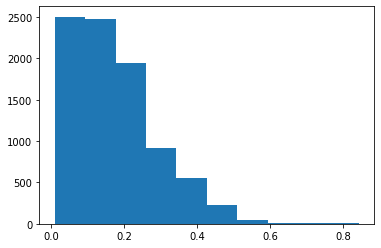

In [23]:
# plt.plot(aa1['stress_probability'][18000:19900])
# plt.plot(aa1['imputed'][18000:19900])
plt.hist(aa1[aa1.imputed.isin([0])]['stress_probability'],10)

In [ ]:
data = CC.get_stream('org.md2k.autosense.rip.stress.likelihood.imputed')

In [ ]:
data.count()

In [ ]:
df = pd.DataFrame(np.random.randn(10,3),columns=['a','b','c'])

In [ ]:
df

In [ ]:
df[['a','b']].iloc[8-3:8]

In [ ]:
df

In [ ]:
for i,row in df.iterrows():
    print(i)

In [ ]:
stress_data = CC.get_stream('org.md2k.autosense.rip.stress.likelihood')._data.toPandas()
# quality_data = CC.get_stream('org.md2k.autosense.rip.quality.60seconds')._data.toPandas()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
# plt.plot(stress_data['timestamp'][stress_data.user==stress_data['user'].iloc[20000]][:300],
#          stress_data['stress_likelihood'][stress_data.user==stress_data['user'].iloc[20000]][:300])
plt.hist(stress_data['stress_likelihood'],20)
plt.show()
stress_data.shape

In [ ]:
import pickle
pickle.dump(stress_data,open('./rice_data/stress_rip_only_no_c6_nw.p','wb'))
pickle.dump(quality_data,open('./rice_data/rip_quality_60_seconds_nw.p','wb'))

In [ ]:
stress_data.shape

In [ ]:
ds = CC.get_stream('org.md2k.motionsensehrv.ppg.left.stress.md2k_aa_rice.imputed.ffill')
emas = CC.get_stream("perceived.stress.score--org.md2k.ema_scheduler--phone").drop(*['timestamp',
                                                                                    'localtime',
                                                                                    'version'])
all_stress = ds.join(emas,on=['user','window'],how='left')

In [ ]:
a = [1,2,3,4,5]

In [ ]:
a.count(1)